https://medium.com/the-owl/k-fold-cross-validation-in-keras-3ec4a3a00538

# Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import KFold, StratifiedKFold
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import load_model
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Importing Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DIR_MAIN = '/content/drive/MyDrive/CCPS Summer Internship/SplitDataset/'

TEST_DIR = DIR_MAIN + 'test'
TRAIN_DIR = DIR_MAIN + 'train'
VAL_DIR = DIR_MAIN + 'val'

In [ ]:
IMG_SHAPE  = 224
batch_size = 32

# VGG16

In [ ]:
kf = KFold(n_splits = 2)

In [ ]:
def get_model_name(k):
    return 'model_crossvalvgg'+str(k)+'.h5'

In [ ]:
image_gen_train = ImageDataGenerator(width_shift_range=0.1,
                         height_shift_range=0.1,
                         zoom_range=0.3,
                         fill_mode='nearest',
                         horizontal_flip = True,
                                     rescale = 1./255)

train_data_gen = image_gen_train.flow_from_directory(
batch_size = batch_size,
directory = TRAIN_DIR,
shuffle= True,
target_size = (IMG_SHAPE,IMG_SHAPE),
class_mode = 'categorical')


Found 2677 images belonging to 4 classes.


In [ ]:
train_image_names = train_data_gen.filenames

train_class_labels = train_data_gen.labels

df = pd.DataFrame(list(zip(train_image_names,train_class_labels)),columns =['X', 'Y'])

df

,X,Y
0,Benign/Benign_0_1034.jpg,0
1,Benign/Benign_0_1039.jpg,0
2,Benign/Benign_0_1066.jpg,0
3,Benign/Benign_0_1075.jpg,0
4,Benign/Benign_0_1111.jpg,0
...,...,...
2672,Pro/WBC-Malignant-Pro-796.jpg,3
2673,Pro/WBC-Malignant-Pro-798.jpg,3
2674,Pro/WBC-Malignant-Pro-800.jpg,3
2675,Pro/WBC-Malignant-Pro-801.jpg,3


In [ ]:
VALIDATION_ACCURACY = []
VALIDAITON_LOSS = []

save_dir = '/content/sample_data/'
fold_var = 1
Y = df[['Y']]
n=2677


for train_index, val_index in kf.split(np.zeros(n),Y):

  image_gen_train = ImageDataGenerator(width_shift_range=0.1,
                         height_shift_range=0.1,
                         zoom_range=0.3,
                         fill_mode='nearest',
                         horizontal_flip = True,
                                       rescale = 1./255)


  train_data_gen = image_gen_train.flow_from_directory(
  batch_size = batch_size,
  directory = TRAIN_DIR,
  shuffle= True,
  target_size = (IMG_SHAPE,IMG_SHAPE),
  class_mode = 'categorical')

  image_generator_validation = ImageDataGenerator(rescale=1./255)

  val_data_gen = image_generator_validation.flow_from_directory(
    batch_size=batch_size,
    directory=VAL_DIR,
    target_size=(IMG_SHAPE, IMG_SHAPE),
    class_mode='categorical')

  image_gen_test = ImageDataGenerator(rescale=1./255)

  test_data_gen = image_gen_test.flow_from_directory(
    batch_size=batch_size,
    directory=TEST_DIR,
    target_size=(IMG_SHAPE, IMG_SHAPE),
    class_mode='categorical')

	# CREATE NEW MODEL
  pre_trained_model = tf.keras.applications.VGG16(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
  for layer in pre_trained_model.layers:
    print(layer.name)
    layer.trainable = False

  last_layer = pre_trained_model.get_layer('block5_pool')
  last_output = last_layer.output
  x = tf.keras.layers.GlobalMaxPooling2D()(last_output)
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.5)(x)
  x = tf.keras.layers.Dense(4, activation='softmax')(x)

  model = tf.keras.Model(pre_trained_model.input, x)
  model.compile(optimizer='adam', loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])

	# CREATE CALLBACKS
  checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(fold_var),
							monitor='val_accuracy', verbose=1,
							save_best_only=True, mode='max')
  callbacks_list = [checkpoint]


	# FIT THE MODEL
  steps_per_epoch = np.ceil(train_data_gen.samples/train_data_gen.batch_size)
  val_steps_per_epoch = np.ceil(val_data_gen.samples/val_data_gen.batch_size)
  hist = model.fit(
  train_data_gen,
  epochs=5,
  verbose=1,
  steps_per_epoch=steps_per_epoch,
  validation_data=val_data_gen,
  validation_steps=val_steps_per_epoch).history

	# LOAD BEST MODEL to evaluate the performance of the model
  model.save("/content/sample_data/modelcrossvalvgg"+str(fold_var)+".h5")

  model.load_weights("/content/sample_data/modelcrossvalvgg"+str(fold_var)+".h5")

  results = model.evaluate(val_data_gen)
  results = dict(zip(model.metrics_names,results))

  VALIDATION_ACCURACY.append(results['accuracy'])
  VALIDAITON_LOSS.append(results['loss'])

  tf.keras.backend.clear_session()

  fold_var += 1

Found 2677 images belonging to 4 classes.
Found 764 images belonging to 4 classes.
Found 385 images belonging to 4 classes.
58889256/58889256 [==============================] - 0s 0us/step
input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
Epoch 1/5
84/84 [==============================] - 799s 9s/step - loss: 0.7414 - accuracy: 0.7112 - val_loss: 0.4148 - val_accuracy: 0.8691
Epoch 2/5
84/84 [==============================] - 51s 599ms/step - loss: 0.4317 - accuracy: 0.8446 - val_loss: 0.3661 - val_accuracy: 0.8599
Epoch 3/5
84/84 [==============================] - 50s 592ms/step - loss: 0.4114 - accuracy: 0.8431 - val_loss: 0.3508 - val_accuracy: 0.8743
Epoch 4/5
84/84 [==============================] - 51s 605ms/step - loss: 0.3605 - accuracy: 0.8741 - val_loss: 0.3815 - val_accuracy: 0.8586
Epoch 5/

model1

In [ ]:
# Load the model # check output model name and load model to make predictions
ALL_model = tf.keras.models.load_model('/content/sample_data/modelcrossvalvgg1.h5')

Get images and labels batch from validation dataset generator

In [ ]:
val_image_batch, val_label_batch = next(iter(val_data_gen))
true_label_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (32, 224, 224, 3)


In [ ]:
dataset_labels = sorted(train_data_gen.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

['Benign' 'Early' 'Pre' 'Pro']


# Testing Our Model
Let's calculate predictions for the entire batch.

In [ ]:
tf_model_predictions = ALL_model.predict(val_image_batch)
tf_pred_dataframe = pd.DataFrame(tf_model_predictions)
tf_pred_dataframe.columns = dataset_labels
print("Prediction results for the first elements")
tf_pred_dataframe.head()

1/1 [==============================] - 0s 224ms/step
Prediction results for the first elements


,Benign,Early,Pre,Pro
0,0.009622,0.043195,0.947135,0.000049
1,0.001128,0.955987,0.042881,0.000005
2,0.002995,0.996031,0.000887,0.000087
3,0.671555,0.291248,0.030852,0.006346
4,0.793358,0.177870,0.011591,0.017180


Print images batch and labels predictions

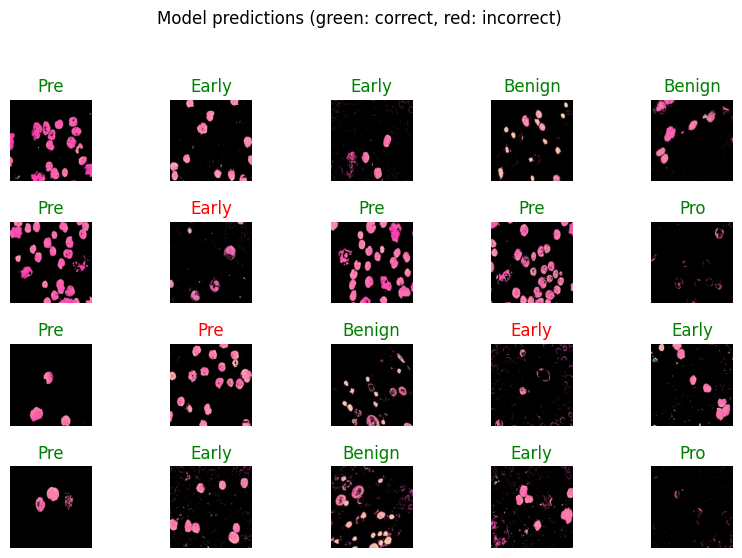

In [ ]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(20):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

## Accuracy

In [ ]:
results = model.evaluate(val_image_batch, val_label_batch)

1/1 [==============================] - 0s 273ms/step - loss: 0.3203 - accuracy: 0.9062


In [ ]:
# Print the accuracy
accuracy = results[1]  # Assuming accuracy is the second metric
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 90.62%


model2

In [ ]:
# Load the model
ALL_model = tf.keras.models.load_model('/content/sample_data/modelcrossvalvgg2.h5')

Get images and labels batch from validation dataset generator

In [ ]:
val_image_batch, val_label_batch = next(iter(val_data_gen))
true_label_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (32, 224, 224, 3)


In [ ]:
dataset_labels = sorted(train_data_gen.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

['Benign' 'Early' 'Pre' 'Pro']


# Testing Our Model
Let's calculate predictions for the entire batch.

In [ ]:
tf_model_predictions = ALL_model.predict(val_image_batch)
tf_pred_dataframe = pd.DataFrame(tf_model_predictions)
tf_pred_dataframe.columns = dataset_labels
print("Prediction results for the first elements")
tf_pred_dataframe.head()

1/1 [==============================] - 0s 275ms/step
Prediction results for the first elements


,Benign,Early,Pre,Pro
0,0.878111,0.006046,0.060813,5.503023e-02
1,0.000017,0.000088,0.999895,4.519457e-08
2,0.117090,0.369816,0.498851,1.424292e-02
3,0.021301,0.082409,0.894346,1.944321e-03
4,0.518330,0.002838,0.009243,4.695890e-01


Print images batch and labels predictions

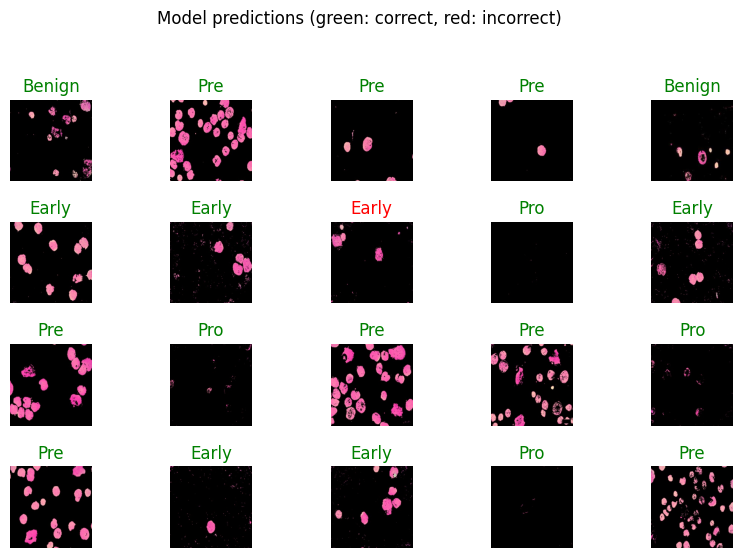

In [ ]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(20):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

## Accuracy

In [ ]:
results = model.evaluate(val_image_batch, val_label_batch)

1/1 [==============================] - 0s 181ms/step - loss: 0.3018 - accuracy: 0.8750


In [ ]:
# Print the accuracy
accuracy = results[1]  # Assuming accuracy is the second metric
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 87.50%
